In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive',force_remount=True)
sys.path.insert(0,'/content/drive/MyDrive/EPF notebooks/deep_learning_project')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, random_split, SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms


import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
import seaborn as sns

from package import CNN

# **K-fold Validation**

In [3]:
transforms = transforms.Compose([
        transforms.Resize([120,120]), # the image are not all equal in size, we need to define a standard size
        transforms.ToTensor() # converts images to torch Tensors and rescales pixels to [0;1] 
    ])

train_dataset = torchvision.datasets.GTSRB(
    root='.',
    split='train',
    transform=transforms,
    download=True
)

test_dataset = torchvision.datasets.GTSRB(
    root='.',
    split='test',
    transform=transforms,
    download=True
)

  0%|          | 0/187490228 [00:00<?, ?it/s]

Extracting gtsrb/GTSRB-Training_fixed.zip to gtsrb


  0%|          | 0/88978620 [00:00<?, ?it/s]

Extracting gtsrb/GTSRB_Final_Test_Images.zip to gtsrb


  0%|          | 0/99620 [00:00<?, ?it/s]

Extracting gtsrb/GTSRB_Final_Test_GT.zip to gtsrb


In [4]:
torch.manual_seed(17)
dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
splits=KFold(n_splits=4,shuffle=True,random_state=17)

In [5]:
def train_epoch(model,device,dataloader,criterion,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for inputs, targets in dataloader:

        inputs,targets = inputs.to(device),targets.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output,targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predictions = torch.max(output.data, 1)
        train_correct += (predictions == targets).sum().item()

    return train_loss,train_correct
  
def valid_epoch(model,device,dataloader,criterion):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for inputs, targets in dataloader:

        inputs,targets = inputs.to(device),targets.to(device)
        output = model(inputs)
        loss = criterion(output,targets)
        valid_loss+= loss.item()*inputs.size(0)
        _, predictions = torch.max(output.data,1)
        val_correct+= (predictions == targets).sum().item()

    return valid_loss,val_correct

In [6]:
history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
criterion = nn.CrossEntropyLoss()

BATCH_SIZE = 128
EPOCHS = 10

cuda:0


In [7]:
for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print(f'Fold: {fold+1}')

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(
        dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
    test_loader = DataLoader(
        dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

    model = CNN(43)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(EPOCHS):
        train_loss, train_correct = train_epoch(
            model, device, train_loader, criterion, optimizer)
        test_loss, test_correct = valid_epoch(
            model, device, test_loader, criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print(f"Epoch:{epoch + 1}/{EPOCHS} AVG Training Loss:{train_loss:.3f} AVG Test Loss:{test_loss:.3f},\
            AVG Training Acc {train_acc:.2f}, AVG Test Acc {test_acc:.2f}")
        
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

Fold: 1
Epoch:1/10 AVG Training Loss:0.877 AVG Test Loss:0.211,            AVG Training Acc 75.59, AVG Test Acc 94.09
Epoch:2/10 AVG Training Loss:0.163 AVG Test Loss:0.077,            AVG Training Acc 95.29, AVG Test Acc 97.77
Epoch:3/10 AVG Training Loss:0.103 AVG Test Loss:0.057,            AVG Training Acc 96.90, AVG Test Acc 98.27
Epoch:4/10 AVG Training Loss:0.060 AVG Test Loss:0.048,            AVG Training Acc 98.14, AVG Test Acc 98.64
Epoch:5/10 AVG Training Loss:0.053 AVG Test Loss:0.036,            AVG Training Acc 98.36, AVG Test Acc 98.97
Epoch:6/10 AVG Training Loss:0.054 AVG Test Loss:0.037,            AVG Training Acc 98.26, AVG Test Acc 98.95
Epoch:7/10 AVG Training Loss:0.044 AVG Test Loss:0.031,            AVG Training Acc 98.60, AVG Test Acc 98.98
Epoch:8/10 AVG Training Loss:0.029 AVG Test Loss:0.024,            AVG Training Acc 99.06, AVG Test Acc 99.33
Epoch:9/10 AVG Training Loss:0.022 AVG Test Loss:0.027,            AVG Training Acc 99.33, AVG Test Acc 99.30
Ep

# **Performances for each testing set**

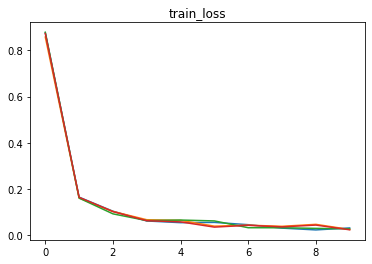

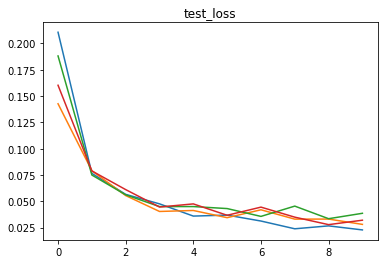

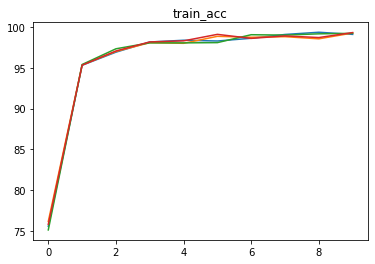

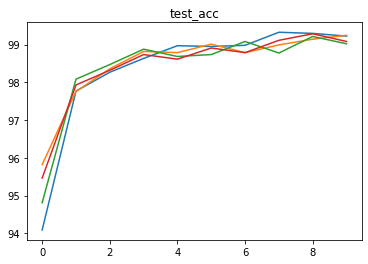

In [24]:
def plot_history(series:list, title:str):
  series = np.array(series).reshape(4, -1)
  plt.figure()
  for fold in series:
    plt.plot(fold)
  plt.title(title)
  plt.show()

for i in history.keys():
  plot_history(history[i], title=i)

# **Conclusion**

After implementing 4-fold cross validation, we can see that the model is learning similarly on every group of 3 folds and achieving the same results on the 4th.

We can therefore conclude that the model is able to *__generalize__* well.